In [11]:
from typing import List, Dict, Tuple
from pangeo_forge_recipes.patterns import pattern_from_file_sequence
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

import aiohttp
import asyncio
import time


def recipe_from_urls(urls, kwargs):
    # parse kwargs for different steps of the recipe
    pattern_kwargs = kwargs.get("pattern_kwargs", {})
    recipe_kwargs = kwargs.get("recipe_kwargs", {})

    pattern = pattern_from_file_sequence(urls, "time", **pattern_kwargs)
    recipe = XarrayZarrRecipe(
        pattern, xarray_concat_kwargs={"join": "exact"}, **recipe_kwargs
    )
    return recipe


async def is_netcdf3(session: aiohttp.ClientSession, url: str) -> bool:
    """Simple check to determine the netcdf file version behind a url.
    Requires the server to support range requests"""
    headers = {"Range": "bytes=0-2"}
    # TODO: how should i handle it if these are failing?
    # TODO: need to implement a retry here too
    # TODO: I believe these are independent of the search nodes? So we should not retry these with another node? I might need to look into what 'replicas' mean in this context.
    async with session.get(url, headers=headers) as resp:
        status_code = resp.status
        if not status_code == 206:
            raise RuntimeError(f"Range request failed with {status_code} for {url}")
        head = await resp.read()
        return "CDF" in str(head)


def _build_params(iid: str) -> Dict[str, str]:
    params = {
        "type": "File",
        "retracted": "false",
        "replica": "false",
        "format": "application/solr+json",
        # "fields": ["url", "size", "retracted", "table_id", "title","instance_id"], # TODO: why does this not work? Ill revisit when I am tuning performance, for now get all
        "latest": "true",
        "distrib": "true",
        # "limit": 500, # TODO: Should this be less?
    }
    facets = facets_from_iid(iid)
    params.update(facets)
    # searching with version does not work. So what I will do here is delete the version, and later check if the version of the iid is equal to the files found, otherwise error out. TODO
    del params["version"]
    return params, facets  # TODO: Clean this up and possibly only have one output


async def _esgf_api_request(
    session: aiohttp.ClientSession,
    node: str,
    params: Dict[str, str],
    facets: Dict[str, str],
) -> Dict[str, str]:
    resp = await session.get(node, params=params)
    status_code = resp.status
    if not status_code == 200:
        raise RuntimeError(f"Request failed with {status_code} for {iid}")
    resp_data = await resp.json(
        content_type="text/json"
    )  # https://stackoverflow.com/questions/48840378/python-attempt-to-decode-json-with-unexpected-mimetype
    resp_data = resp_data["response"]["docs"]
    if len(resp_data) == 0:
        raise ValueError(f"No Files were found for {iid}")
    return resp_data
    
def get_timesteps_simple(dates, table_id):
    assert 'mon' in table_id # this needs some more careful treatment for other timefrequencies. 
    timesteps = [(int(d[1][0:4]) - int(d[0][0:4])) *12 + (int(d[1][4:6]) - int(d[0][4:6]) + 1) for d in dates]
    
    return timesteps
    

async def response_data_processing(
    session: aiohttp.ClientSession,
    response_data: Dict[str, str],
    iid: str,
    facets: Dict[str, str],
) -> (List[str], Dict[str, Dict[str, str]]):
    # Extract info
    raw_urls, sizes, retracted, table_ids, titles = zip(
        *[
            (rd["url"], rd["size"], rd["retracted"], rd["table_id"], rd["title"])
            for rd in response_data
        ]
    )

    # Check consistency with iid input
    _check_response_facets_consistency(facets, response_data)

    # this takes care of checking that all table_ids are the same, so I can do this
    table_id = table_ids[0][0]

    # pick http url
    urls = [_parse_url_type(url[0]) for url in raw_urls]

    # Check for netcdf version early so that we can fail quickly
    # print(urls)
    print(f"{iid}: Check for netcdf 3 files")
    pattern_kwargs = {}
    netcdf3_check = await is_netcdf3(session, urls[-1])
    # netcdf3_check = is_netcdf3(urls[-1]) #TODO This works, but this is the part that is slow as hell, so I should async this one...
    if netcdf3_check:
        pattern_kwargs["file_type"] = "netcdf3"

    # Check retractions (this seems a bit redundant, but what the heck
    if not all(r is False for r in retracted):
        print("retracted", retracted)
        raise ValueError(f"Query for {iid} contains retracted files")
        
    # extract date range from filename
    # TODO: Is there a more robust way to do this?
    # otherwise maybe use `id` (harder to parse)
    dates = [t.replace(".nc", "").split("_")[-1].split("-") for t in titles]

    timesteps = get_timesteps_simple(dates, table_id)
    
    print(f"Dates for each file: {dates}")
    print(f"Size per file in MB: {[f/1e6 for f in sizes]}")
    print(f"Inferred timesteps per file: {timesteps}")
    element_sizes = [size / n_t for size, n_t in zip(sizes, timesteps)]

    ### Determine kwargs
    # MAX_SUBSET_SIZE=1e9 # This is an option if the revised subsetting still runs into errors.
    MAX_SUBSET_SIZE = 500e6
    DESIRED_CHUNKSIZE = 200e6
    # TODO: We need a completely new logic branch which checks if the total size (sum(filesizes)) is smaller than a desired chunk
    target_chunks = {
        "time": choose_chunksize(
            allowed_divisors[table_id],
            DESIRED_CHUNKSIZE,
            element_sizes,
            timesteps,
            include_last=False,
        )
    }

    # dont even try subsetting if none of the files is too large
    if max(sizes) <= MAX_SUBSET_SIZE:
        subset_input = 0
    else:
        ## Determine subset_input parameters given the following constraints
        # - Needs to keep the subset size below MAX_SUBSET_SIZE
        # - (Not currently implemented) Resulting subsets should be evenly dividable by target_chunks (except for the last file, that can be odd). This might ultimately not be required once we figure out the locking issues. I cannot fulfill this right now with the dataset structure where often the first and last files have different number of timesteps than the 'middle' ones.

        smallest_divisor = int(
            max(sizes) // MAX_SUBSET_SIZE + 1
        )  # need to subset at least with this to stay under required subset size
        subset_input = smallest_divisor

    recipe_kwargs = {"target_chunks": target_chunks}
    if subset_input > 1:
        recipe_kwargs["subset_inputs"] = {"time": subset_input}

    print(
        f"Will result in max chunksize of {max(element_sizes)*target_chunks['time']/1e6}MB"
    )

    # sort urls in decending time order (to be able to pass them directly to the pangeo-forge recipe)
    end_dates = [a[-1] for a in dates]
    urls = [url for _, url in sorted(zip(end_dates, urls))]

    kwargs = {"recipe_kwargs": recipe_kwargs, "pattern_kwargs": pattern_kwargs}
    print(f"Dynamically determined kwargs: {kwargs}")
    return urls, kwargs


async def iid_request(session: aiohttp.ClientSession, iid: str, nodes: List[str]):
    params, facets = _build_params(iid)
    urls = None
    kwargs = None

    for node in nodes:
        try:
            print(f"Requesting data for Node: {node} and {iid}...")
            response_data = await _esgf_api_request(
                session, node, params, facets
            )  # TODO: The facets treatment is clunky
            urls, kwargs = await response_data_processing(
                session, response_data, iid, facets
            )
            break
        except Exception as e:
            print(f"Request for Node:{node} and {iid} failed due to {e}")

    return urls, kwargs


def _parse_url_type(url: str) -> str:
    """Checks that url is of a desired type (currently only http) and removes appended text"""
    # From naomis code, in case we need to support OPENDAP
    #         resp = resp["docs"]
    #         offset += len(resp)
    #         # print(offset,numFound,len(resp))
    #         for d in resp:
    #             dataset_id = d["dataset_id"]
    #             dataset_size = d["size"]
    #             for f in d["url"]:
    #                 sp = f.split("|")
    #                 if sp[-1] == files_type:
    #                     url = sp[0]
    #                     if sp[-1] == "OPENDAP":
    #                         url = url.replace(".html", "")
    #                     dataset_url = url
    #             all_frames += [[dataset_id, dataset_url, dataset_size]]

    split_url = url.split("|")
    if split_url[-1] != "HTTPServer":
        raise ValueError("This recipe currently only supports HTTP links")
    else:
        return split_url[0]


def facets_from_iid(iid: str) -> Dict[str, str]:
    """Translates iid string to facet dict according to CMIP6 naming scheme"""
    iid_name_template = "mip_era.activity_id.institution_id.source_id.experiment_id.variant_label.table_id.variable_id.grid_label.version"
    facets = {}
    for name, value in zip(iid_name_template.split("."), iid.split(".")):
        facets[name] = value
    return facets


def choose_chunksize(
    chunksize_candidates: List[int],
    max_size: float,
    element_size_lst: List[float],
    timesteps_lst: List[int],
    include_last: bool = True,
) -> int:
    """Determines the ideal chunksize based on a list of preferred `divisors` and
    informations about the input files
    given the following constraints:
    - The resulting chunks are smaller than `max_size`
    - The determined chunksize will divide each file into even chunks
      (if `include_last` is false, the last file is allowed to have uneven chunks,
      but cannot be larger than the number of timesteps in the last file)

    Parameters
    ----------
    candidate_chunks : List[int]
        A list of chunksizes to consider.
    max_size : float
        Maximum size (in bytes) of the resulting chunksize
    element_size_lst : List[float]
        List of sizes (in bytes) of a single element along the chunking dimension (often time)
        for each of the input elements (files).
    timesteps_lst : List[int]
        List of timesteps for input elements
    include_last : bool, optional
        Option to include or exclude the last element from above lists, by default True.
        If number of elements of lists above is 1, this is always True

    Returns
    -------
    int
        Choosen chunksize
    """
    #     # TODO: infer clean divisions of the divisor (e.g. [1, 2, 3, 4, 6] for 12) automatically here
    #     candidate_chunks = divisors[:-1]+list(range(divisors[-1], max(timesteps_lst), divisors[-1]))

    if (
        not include_last and len(timesteps_lst) > 1
    ):  # we cannot exclude the last one if there is only one element.
        chunksize_filtered = [
            cs
            for cs in chunksize_candidates
            if all(
                nt % cs == 0 for nt in timesteps_lst[:-1]
            )  # do I need and timesteps_lst[-1] > cs
        ]
    else:
        chunksize_filtered = [
            cs
            for cs in chunksize_candidates
            if all(nt % cs == 0 for nt in timesteps_lst)
        ]
    output_chunksizes = [
        max([cs for cs in chunksize_filtered if cs * element_size <= max_size])
        for element_size in element_size_lst
    ]
    # what do we do if somehow this ends up being different? Take the min/max?
    if not all(oc == output_chunksizes[0] for oc in output_chunksizes):
        raise ValueError("Determined chunksizes are not all equal.")
    else:
        return output_chunksizes[0]


def _check_response_facets_consistency(
    facets: Dict[str, str], file_resp: Dict[str, str]
):
    # Check that all responses indeed have the same attributes
    # (error out on e.g. mixed versions for now)
    # TODO: We might allow mixed versions later, but need to be careful with that!
    check_facets = [
        "mip_era",
        "activity_id",
        "institution_id",
        "source_id",
        "experiment_id",
        "variant_label",
        "table_id",
        "variable_id",
        "grid_label",
        "version",
    ]

    def _check_single_element_list(lst):
        # double check that the facet returns are just a single element
        [out] = lst  # errors on a list with more than one element
        return out

    for fac in check_facets:
        file_facets = [_check_single_element_list(f[fac]) for f in file_resp]
        if not all(ff == file_facets[0] for ff in file_facets):
            raise ValueError(
                f"Found non-matching values for {fac} in search query response. Got {file_facets}"
            )


## global variables
nodes = [
    "https://esgf-node.llnl.gov/esg-search/search",
    "https://esgf-data.dkrz.de/esg-search/search",
    "https://esgf-node.ipsl.upmc.fr/esg-search/search",
    "https://esgf-index1.ceda.ac.uk/esg-search/search",
]


# For certain table_ids it is preferrable to have time chunks that are a multiple of e.g. 1 year for monthly data.
monthly_divisors = sorted(
    [1, 3, 6, 12, 12 * 3]
    + list(range(12 * 5, 12 * 200, 12 * 5))
    + [684, 1026, 2052]
    # the last list accomodates some special cases for `DAMIP` files (which are often only one file, but with a very odd number of years (e.g.  171 years for hist-aer 🤷).
    # TODO: I might not want to allow this in the ocean and ice fields. Lets see
)

allowed_divisors = {
    "Omon": monthly_divisors,
    "SImon": monthly_divisors,
    "Amon": monthly_divisors,
}  # Add table_ids and allowed divisors as needed


## Recipe Generation
iids = [
    "CMIP6.DAMIP.BCC.BCC-CSM2-MR.hist-aer.r1i1p1f1.Amon.pr.gn.v20190507",
    "CMIP6.DAMIP.BCC.BCC-CSM2-MR.hist-aer.r2i1p1f1.Amon.pr.gn.v20190507",
    "CMIP6.DAMIP.BCC.BCC-CSM2-MR.hist-aer.r3i1p1f1.Amon.pr.gn.v20190508",
    "CMIP6.DAMIP.CAS.FGOALS-g3.hist-aer.r1i1p1f1.Amon.pr.gn.v20200411",
    "CMIP6.DAMIP.CAS.FGOALS-g3.hist-aer.r2i1p1f1.Amon.pr.gn.v20200411",
    "CMIP6.DAMIP.CAS.FGOALS-g3.hist-aer.r3i1p1f1.Amon.pr.gn.v20200411",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r10i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r10i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r11i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r11i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r12i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r12i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r13i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r13i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r14i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r14i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r15i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r15i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r1i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r1i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r2i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r2i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r3i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r3i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r4i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r4i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r5i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r5i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r6i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r6i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r7i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r7i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r8i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r8i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r9i1p1f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CCCma.CanESM5.hist-aer.r9i1p2f1.Amon.pr.gn.v20190429",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r10i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r1i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r2i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r3i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r4i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r5i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r6i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r7i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r8i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CNRM-CERFACS.CNRM-CM6-1.hist-aer.r9i1p1f2.Amon.pr.gr.v20190308",
    "CMIP6.DAMIP.CSIRO-ARCCSS.ACCESS-CM2.hist-aer.r1i1p1f1.Amon.pr.gn.v20201120",
    "CMIP6.DAMIP.CSIRO-ARCCSS.ACCESS-CM2.hist-aer.r2i1p1f1.Amon.pr.gn.v20201120",
    "CMIP6.DAMIP.CSIRO-ARCCSS.ACCESS-CM2.hist-aer.r3i1p1f1.Amon.pr.gn.v20201120",
    "CMIP6.DAMIP.CSIRO.ACCESS-ESM1-5.hist-aer.r1i1p1f1.Amon.pr.gn.v20200615",
    "CMIP6.DAMIP.CSIRO.ACCESS-ESM1-5.hist-aer.r2i1p1f1.Amon.pr.gn.v20200615",
    "CMIP6.DAMIP.CSIRO.ACCESS-ESM1-5.hist-aer.r3i1p1f1.Amon.pr.gn.v20200615",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r10i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r1i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r2i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r3i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r4i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r5i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r6i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r7i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r8i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.IPSL.IPSL-CM6A-LR.hist-aer.r9i1p1f1.Amon.pr.gr.v20180914",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r10i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r1i1p1f1.Amon.pr.gn.v20190705",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r2i1p1f1.Amon.pr.gn.v20190705",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r4i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r5i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r6i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r7i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r8i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r9i1p1f1.Amon.pr.gn.v20201228",
    "CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-aer.r1i1p1f3.Amon.pr.gn.v20190814",
    "CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-aer.r2i1p1f3.Amon.pr.gn.v20190815",
    "CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-aer.r3i1p1f3.Amon.pr.gn.v20190814",
    "CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-aer.r4i1p1f3.Amon.pr.gn.v20190814",
    "CMIP6.DAMIP.MOHC.HadGEM3-GC31-LL.hist-aer.r5i1p1f3.Amon.pr.gn.v20211123",
    "CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-aer.r1i1p1f1.Amon.pr.gn.v20190320",
    "CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-aer.r2i1p1f1.Amon.pr.gn.v20200327",
    "CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-aer.r3i1p1f1.Amon.pr.gn.v20190320",
    "CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-aer.r4i1p1f1.Amon.pr.gn.v20200327",
    "CMIP6.DAMIP.MRI.MRI-ESM2-0.hist-aer.r5i1p1f1.Amon.pr.gn.v20190320",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r1i1p1f1.Amon.pr.gn.v20180821",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r1i1p1f2.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r1i1p3f1.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r2i1p1f1.Amon.pr.gn.v20180821",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r2i1p1f2.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r2i1p3f1.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r3i1p1f1.Amon.pr.gn.v20180822",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r3i1p1f2.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r3i1p3f1.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r4i1p1f1.Amon.pr.gn.v20180823",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r4i1p1f2.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r4i1p3f1.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r5i1p1f1.Amon.pr.gn.v20180823",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r5i1p1f2.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NASA-GISS.GISS-E2-1-G.hist-aer.r5i1p3f1.Amon.pr.gn.v20191226",
    "CMIP6.DAMIP.NCAR.CESM2.hist-aer.r1i1p1f1.Amon.pr.gn.v20200206",
    "CMIP6.DAMIP.NCAR.CESM2.hist-aer.r3i1p1f1.Amon.pr.gn.v20200305",
    "CMIP6.DAMIP.NCC.NorESM2-LM.hist-aer.r1i1p1f1.Amon.pr.gn.v20190920",
    "CMIP6.DAMIP.NCC.NorESM2-LM.hist-aer.r2i1p1f1.Amon.pr.gn.v20190920",
    "CMIP6.DAMIP.NCC.NorESM2-LM.hist-aer.r3i1p1f1.Amon.pr.gn.v20190920",
    "CMIP6.DAMIP.NOAA-GFDL.GFDL-ESM4.hist-aer.r1i1p1f1.Amon.pr.gr1.v20180701",
]


iids = [
    "CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705",
]
# TODO: should implement a retry + backoff (i have seen flaky datasets come back after a few minutes.

# Lets try to implement retrys
async def main(node_list):
    # Lets limit the amount of connections to avoid being flagged
    connector = aiohttp.TCPConnector(
        limit_per_host=10
    )  # Not sure we need a timeout now, but this might be useful in the future
    # combined with a retry.
    timeout = aiohttp.ClientTimeout(total=40)
    async with aiohttp.ClientSession(timeout=timeout, connector=connector) as session:

        tasks = []
        for iid in iids:
            tasks.append(asyncio.ensure_future(iid_request(session, iid, node_list)))

        raw_input = await asyncio.gather(*tasks)
        recipe = {
            iid: recipe_from_urls(urls, kwargs)
            for iid, (urls, kwargs) in zip(iids, raw_input)
            if urls is not None
        }
        return recipe


# If you want to debug this in a jupyter notebook you need to uncomment the code below and instead import main and then do `await main()` (see
#recipes = asyncio.run(main(nodes))
#print("Failed recipes: \n" + "\n".join(sorted(list(set(iids) - set(recipes.keys())))))


In [12]:
recipe = await main(nodes)

Requesting data for Node: https://esgf-node.llnl.gov/esg-search/search and CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705...
CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705: Check for netcdf 3 files
Request for Node:https://esgf-node.llnl.gov/esg-search/search and CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705 failed due to 
Requesting data for Node: https://esgf-data.dkrz.de/esg-search/search and CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705...
CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705: Check for netcdf 3 files
Request for Node:https://esgf-data.dkrz.de/esg-search/search and CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705 failed due to 
Requesting data for Node: https://esgf-node.ipsl.upmc.fr/esg-search/search and CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705...
CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705: Check for netcdf 3 files
Request for 

In [14]:
recipe.keys()

dict_keys(['CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705'])

In [15]:
from pangeo_forge_recipes.recipes import setup_logging
setup_logging()

In [16]:
# Prune the recipe
recipe_pruned = recipe['CMIP6.DAMIP.MIROC.MIROC6.hist-aer.r3i1p1f1.Amon.pr.gn.v20190705'].copy_pruned()

In [ ]:
# Run the recipe
run_function = recipe_pruned.to_function()
run_function()

pangeo_forge_recipes.recipes.xarray_zarr - INFO - Caching input 'Index({DimIndex(name='time', index=0, sequence_len=2, operation=<CombineOp.CONCAT: 2>)})'
pangeo_forge_recipes.storage - INFO - Caching file 'http://esgf-data2.diasjp.net/thredds/fileServer/esg_dataroot/CMIP6/DAMIP/MIROC/MIROC6/hist-aer/r3i1p1f1/Amon/pr/gn/v20190705/pr_Amon_MIROC6_hist-aer_r3i1p1f1_gn_185001-194912.nc'
pangeo_forge_recipes.storage - INFO - Copying remote file 'http://esgf-data2.diasjp.net/thredds/fileServer/esg_dataroot/CMIP6/DAMIP/MIROC/MIROC6/hist-aer/r3i1p1f1/Amon/pr/gn/v20190705/pr_Amon_MIROC6_hist-aer_r3i1p1f1_gn_185001-194912.nc' to cache


In [ ]:
# Check the output
import xarray as xr
cmip6_zarr = xr.open_zarr(recipe_pruned.target_mapper, consolidated=True)
cmip6_zarr

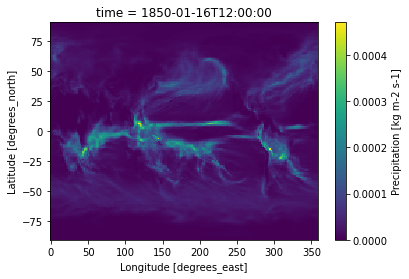

In [29]:
cmip6_zarr.pr.isel(time=0).plot()

In [9]:
import xarray as xr

store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/cmip6-feedstock/CMIP6.CMIP.CCCma.CanESM5.historical.r1i1p1f1.Omon.zos.gn.v20190429.zarr'
ds = xr.open_dataset(store, engine='zarr', chunks={})
ds

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, time: 1980, bnds: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    zos                 (time, j, i) float32 dask.array<chunksize=(360, 291, 360), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/99be0cf0-54b1-405b-b46c-e69c274...
    variable_id:                 zos
    variant_label:               r1i1p1f1
    version:                     v20190429